In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import copy
import json
from tqdm import tqdm
import pickle
import logging
import math
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection
# import patch
from matplotlib.patches import Polygon
from matplotlib.colors import colorConverter
from matplotlib.dates import date2num
from matplotlib.dates import num2date
from matplotlib.dates import DateFormatter
# impor Line2d
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from collections import namedtuple
import datetime

# open pickle logs_by_user_session_labeled
with open('../data/logs_by_user_session_labeled.pkl', 'rb') as f:
    logs_by_user_session_labeled = pickle.load(f)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')


# Draw Timelines

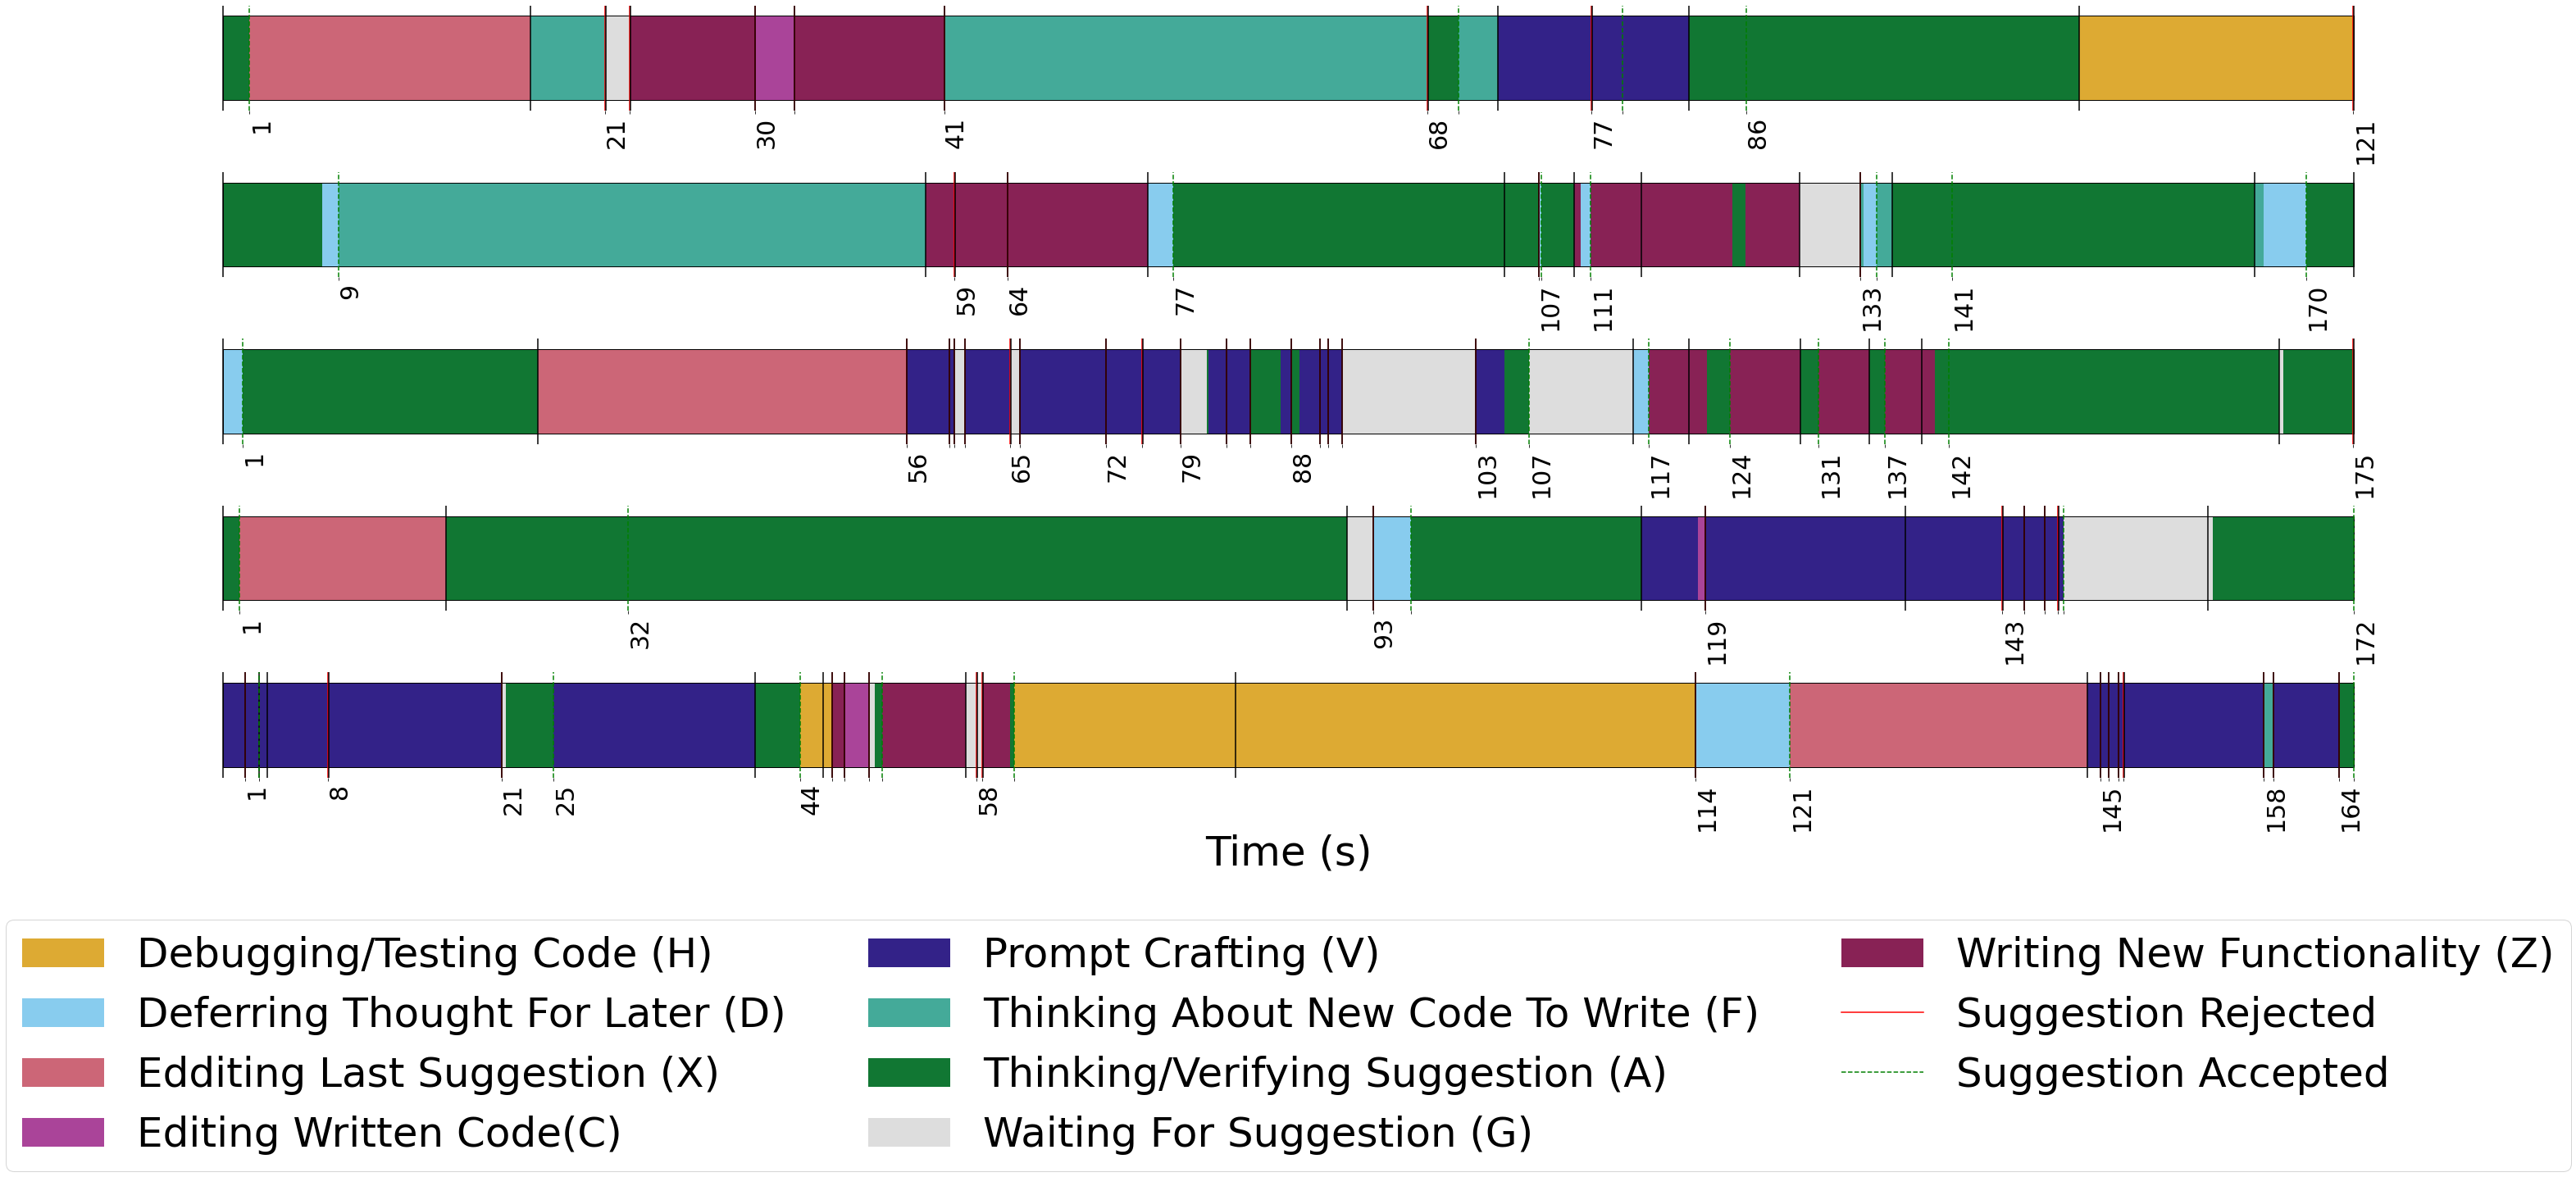

In [13]:

###################################
# To change which users and time window, change the following 
initial_index = 0
user_ids = [4,5,8,6,7]

time_window = 3*60 # in seconds 
max_lenghts = [50] * len(logs_by_user_session_labeled)
###################################
for i in range(len(logs_by_user_session_labeled)):
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # get cummulative times
    times = np.cumsum(times)
    first_index = len(times) - 1
    for j in range(len(times)):
        if times[j] > time_window:
            first_index = j
            break
    max_lenghts[i] = first_index
#print(max_lenghts)
max_lenghts = np.array(max_lenghts)
max_lenghts = max_lenghts[user_ids]

# enumerate user_ids
fig, ax = plt.subplots(len(user_ids))
# for each user_id get state and concatenate
all_states = []
for i, user_id in enumerate(user_ids):
    states = logs_by_user_session_labeled[user_id].LabeledState.to_numpy()[initial_index:max_lenghts[i]]
    all_states.extend(states)

states_unique = np.unique(all_states)
states_unique_dict = {states_unique[i]:i for i in range(len(states_unique))}
# color mapping more distinct colors
# make colors very distinct


cset = namedtuple('Mcset',
            'rose indigo sand green cyan wine teal olive purple pale_grey black white yellow')
colors = cset('#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
            '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
            '#000000', '#FFFFFF', '#DDAA33')

color_mapping = {'Debugging/Testing Code (H)': colors.yellow, 'Deferring Thought For Later (D)': colors.cyan, 'Editing Last Suggestion (X)': colors.rose, 'Editing Written Code(C)': colors.purple, 'Looking up Documentation (N)': colors.olive, 'Not Thinking': colors.white,  'Prompt Crafting (V)': colors.indigo, 'Thinking About New Code To Write (F)': colors.teal, 'Thinking/Verifying Suggestion (A)': colors.green, 'Waiting For Suggestion (G)': colors.pale_grey, 'Writing Documentation (B)': colors.sand, 'Writing New Functionality (Z)': colors.wine}


colormapping = {states_unique[i]:color_mapping[states_unique[i]] for i in range(len(states_unique))}


for id_plot, user_id in enumerate(user_ids):
    states = logs_by_user_session_labeled[user_id].LabeledState.to_numpy()[initial_index:max_lenghts[id_plot]]
    times = logs_by_user_session_labeled[user_id].TimeGenerated.to_numpy()[initial_index:max_lenghts[id_plot]]
    times = [pd.to_datetime(t) for t in times]
    times = [times[i]-times[0] for i in range(len(times)) ]
    times = [t.total_seconds() for t in times]
    actions = logs_by_user_session_labeled[user_id].StateName.to_numpy()[initial_index:max_lenghts[id_plot]]

    data_states = [ (times[i-1], times[i], states[i]) for i in range(1,len(states)) ]
    # states dict to index
    # get all unique values of states

    # color mapping for actions
    colormapping_actions = {'Shown':'black', 'Replay':'black', 'Rejected':'red', 'Accepted': 'green'}
    linestyles = {'Shown':'-', 'Replay':'-', 'Rejected':'-', 'Accepted': '--'}
    # plot data on a timeline
    min_d = 0
    max_d = 0
    for d in data_states:
        if d[0] <= min_d:
            min_d = d[0]
        if d[1] >= max_d:
            max_d = d[1]
        ax[id_plot].axvspan(d[0], d[1], ymin=0.1, ymax= 0.9, facecolor=colormapping[d[2]],  alpha=1)
    ax[id_plot].axvspan(min_d, max_d, ymin=0.1, ymax= 0.9, facecolor = 'None', edgecolor = 'black',  alpha=1)
    # plot actions on a timeline
    # add events for actions
    for i in range(len(actions)):
        if actions[i] in ['Shown', 'Rejected', 'Accepted']:
            ax[id_plot].axvline(times[i], ymin=0, ymax=1, color=colormapping_actions[actions[i]], linestyle=linestyles[actions[i]])
        #ax.text(times[i], 0.8, actions[i], ha='center', va='center')
    #ax.set_xlim(dt.datetime(times[0]), dt.datetime(time[-1]))
    ax[id_plot].set_ylim(0, 1)
    ax[id_plot].set_yticks([])
    # add legend with colormapping

    # add legend for actions with are lines
    if id_plot == len(user_ids)-1:
        ax[id_plot].set_xlabel('Time (s)', fontsize=50)
    #ax[id_plot].set_ylabel('State')
    # convert time to relative time
    # formate times to minute:seconds format
    times_formated = [str(datetime.timedelta(seconds=int(t)))  for t in times]
    # remove first two characters from string
    times_formated = [t[2:] for t in times_formated]
    # add time to plot
    # set xticks to times
    # keep only times for actions
    times_actions = [t for i,t in enumerate(times) if actions[i] in ['Rejected', 'Accepted']]
    ax[id_plot].set_xticks(times_actions)
    #times_formated = [str(datetime.timedelta(seconds=int(t)))  for t in times_actions]    
    #times_formated = [t[2:] for t in times_formated]
    times_formated = [  str(int(t)) for t in times_actions]
    # only keep times_formatted that are atleast 3 apart
    times_x_ticks_labels = []
    for i in range(len(times_formated)):
        if i == 0:
            times_x_ticks_labels.append(times_formated[i])

        elif int(times_formated[i]) - int(times_formated[i-1]) > 3:
            times_x_ticks_labels.append(times_formated[i])
        else:
            times_x_ticks_labels.append('')
    ax[id_plot].set_xticklabels(times_x_ticks_labels)
    # change font size of xticks
    for label in ax[id_plot].xaxis.get_ticklabels():
        label.set_fontsize(30)
    # make x axis labels rotated
    plt.setp(ax[id_plot].get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    # # # show on large figure horizontally
    ax[id_plot].spines['top'].set_visible(False)
    ax[id_plot].spines['right'].set_visible(False)
    ax[id_plot].spines['bottom'].set_visible(False)
    ax[id_plot].spines['left'].set_visible(False)
legend_elements = []
legend_elements = [Patch(facecolor=colormapping[states_unique[i]], label=states_unique[i]) for i in range(len(states_unique))]
# append to legend with actions with vertical dotted line
legend_elements.append(Line2D([0], [0], color='red', linestyle='-', label='Suggestion Rejected'))
legend_elements.append(Line2D([0], [0], color='green', linestyle='--', label='Suggestion Accepted'))
fig.legend(handles=legend_elements, loc = 'lower center', ncol=3, fontsize=50, bbox_to_anchor=(0.5, -0.35))
fig.set_size_inches(40, 3*len(user_ids))
    # flip x axis labels
    #fig.autofmt_xdate()

    # save figure
fig.tight_layout()#rect=[1, 1, 1, 1])
# show legend
#fig.show()

fig.savefig('user_timelines'+'.pdf', dpi=1000 , bbox_inches="tight")


# Plot Graph

In [10]:
all_states = []
all_actions = []
all_times = []
all_states_continuous = []
all_states_list = []
all_times_list = []

all_times_continuous = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    # merge states with same name
    last_state = states[0]
    times_cumalitive = 0
    for i in range(len(states)):
        if states[i] != last_state:
            states_continuous.append(last_state)
            last_state = states[i]
            times_continuous.append(times_cumalitive)
            times_cumalitive = times[i]
        else:
            times_cumalitive += times[i]
    states_continuous.append(last_state)
    times_continuous.append(times_cumalitive)
    
    all_states_list.extend(states)
    all_times_list.extend(times)
    all_states_continuous.extend(states_continuous)
    all_times_continuous.extend(times_continuous)
    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)


In [11]:
from hmmviz import TransGraph
import pandas as pd
import matplotlib.pyplot as plt


T = pd.crosstab(
    pd.Series(all_states_continuous[:-1], name='Today'),
    pd.Series(all_states_continuous[1:], name='Tomorrow'),
    normalize=0
)
'''
T = pd.crosstab(
    pd.Series(all_states_continuous[:-1], name='Today'),
    pd.Series(all_states_continuous[1:], name='Tomorrow'),
    normalize=0
)
'''
graph = TransGraph(T)
# for each element of graph dataframe, if less than 0.1, make it


In [12]:
transition_matrix = np.array(graph.dataframe)
nodes = list(graph.dataframe.index)
# take each string in nodes and add new line if more than 2 words in string
nodes_new = []
for i in range(len(nodes)):
    if len(nodes[i].split(' ')) > 2:
        words = nodes[i].split(' ')
        temp_str = ''
        added_line = False
        for j in range(len(words)-1):
            temp_str += words[j] +' ' 
            if (j == 1 or len(temp_str)> 15) and not added_line:
                temp_str += '\n'
                added_line = True
        nodes_new.append(temp_str)
    else:
        nodes_new.append(nodes[i])
nodes = nodes_new
nodes[3] = 'Editing Written \n Code'
nodes[-2] = 'Writing \n Documentation '
labels_nodes = {}
# color nodes
frequencies = [11.31, 1.39, 11.9,4.28,7.45,0.01,11.56,10.91,22.4,4.2,0.53,14.05]
avg_times = [29.24,  7.34, 24.22, 14.08, 106.51, 11.08, 10.67, 19.67, 10.58, 10.54,  9.12, 13.60]
for i in range(len(nodes)):
    #nodes[i] = nodes[i] + f' \n {avg_times[i]:.2f}s , {frequencies[i]:.2f}per ' 
    labels_nodes[nodes[i]] = f"{nodes[i]}"#  \n {avg_times[i]:.2f}s, {frequencies[i]:.2f}/100 " 
# permute array nodes given new indices
new_permutation = [0,4,1,8,7,5,9,11,3,2,10,6] # list(range(12))#
nodes = [nodes[i] for i in new_permutation]
# new permutation is the new order for nodes
# make new transition matrix that is consistent with new permutation
transition_matrix_new = np.zeros((len(nodes),len(nodes)))
for i in range(len(nodes)):
    for j in range(len(nodes)):
        transition_matrix_new[i][j] = transition_matrix[new_permutation[i]][new_permutation[j]]
transition_matrix = transition_matrix_new

from collections import namedtuple

cset = namedtuple('Mcset',
            'rose indigo sand green cyan wine teal olive purple pale_grey black white yellow')
colors = cset('#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
            '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
            '#000000', '#FFFFFF', '#DDAA33')

color_mapping = {'Debugging/Testing Code (H)': colors.yellow, 'Deferring Thought For Later (D)': colors.cyan, 'Editing Last Suggestion (X)': colors.rose, 'Editing Written Code(C)': colors.purple, 'Looking up Documentation (N)': colors.olive, 'Not Thinking': colors.white,  'Prompt Crafting (V)': colors.indigo, 'Thinking About New Code To Write (F)': colors.teal, 'Thinking/Verifying Suggestion (A)': colors.green, 'Waiting For Suggestion (G)': colors.pale_grey, 'Writing Documentation (B)': colors.sand, 'Writing New Functionality (Z)': colors.wine}
nodes_colors = list(color_mapping.values())
edgecolors  = {k: colors.black for k in color_mapping.keys()}
nodes_colors = [nodes_colors[i] for i in new_permutation]






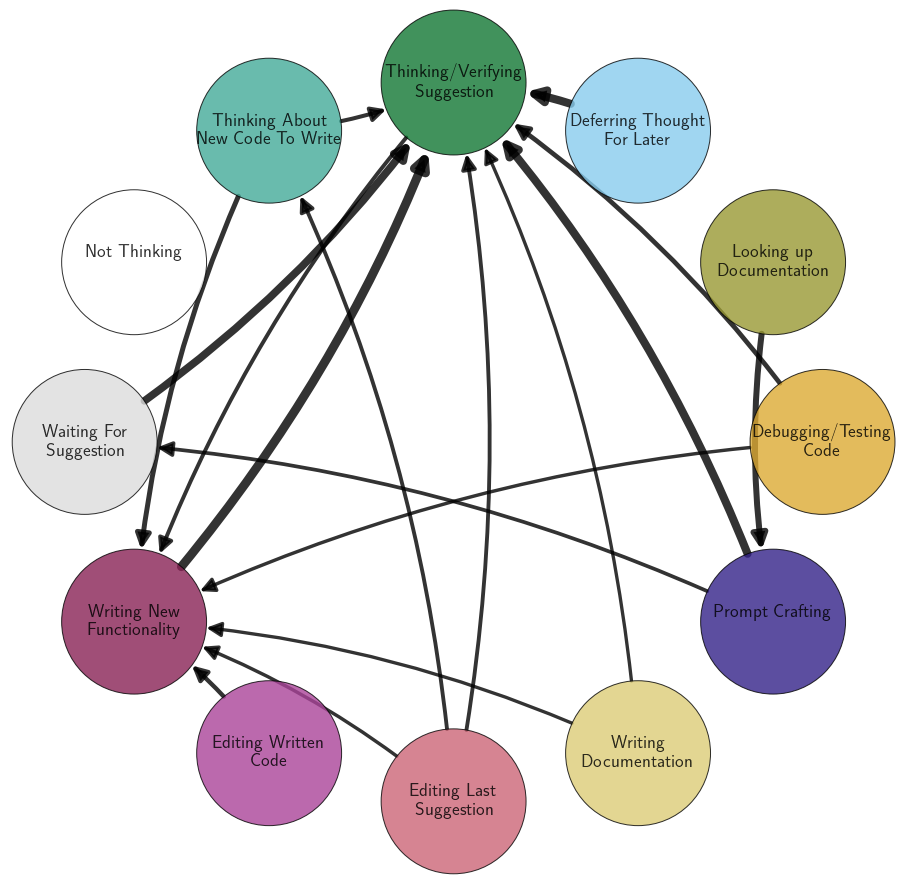

In [13]:
from pyvis.network import Network
import networkx as nx
nx_graph = nx.DiGraph()
# label all nodes with nodes
nx_graph.add_nodes_from(nodes)
# add edges to graph
for i in range(len(nodes)):
    for j in range( len(nodes)):
        if transition_matrix[i][j] > 0.2 and transition_matrix[i][j] < 1:
            nx_graph.add_edge(nodes[i], nodes[j], weight=transition_matrix[i][j]*15)
            # # draw graph
# draw graph with edge weights
# make arrows more intense by multiplying by weight
# print all edges in graph


weights = nx.get_edge_attributes(nx_graph,'weight').values()

# get fig and ax
fig, ax = plt.subplots()


nx.draw(nx_graph, with_labels = True, alpha=0.8,arrows= True, node_size=21000, font_size = 18.5, 
arrowsize=30, arrowstyle='-|>',  width = list(weights), node_color=nodes_colors, edge_color='black',
ax = ax,     connectionstyle="arc3,rad=0.1"  ,  labels = labels_nodes, font_family='sans-serif', font_weight='bold',
pos = nx.circular_layout(nx_graph))
ax.collections[0].set_edgecolor("#000000") # edge color

#plt.show()
# change figure size
fig.set_size_inches(16, 16)
# save graph as pdf
plt.savefig('graph_full.pdf')



# populates the nodes and edges data structures
# show the graph


#nt.from_nx(nx_graph)
#nt.show_buttons(filter_=['physics'])
#nt.show('nx.html')